In [ ]:
%matplotlib inline
import os
import pandas as pd
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

### Reading and observing the data

In [82]:
def load_data(folder_path):
    data = []
    for label, sentiment in enumerate(["neg", "pos"]):  # 0 for neg, 1 for pos
        folder = os.path.join(folder_path, sentiment)
        for filename in os.listdir(folder):
            with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
                data.append((f.read(), label))
    return pd.DataFrame(data, columns=["text", "label"])

data_path = r"C:\Users\asus\Downloads\data\data\training_data"
df = load_data(data_path)
df = shuffle(df, random_state=42).reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1654 non-null   object
 1   label   1654 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.0+ KB


In [83]:
df.head(1)

,text,label
0,"steven spielberg's second epic film on world war ii is an unquestioned masterpiece of film . \nspielberg , ever the student on film , has managed to resurrect the war genre by producing one of its grittiest , and most powerful entries . \nhe also managed to cast this era's greatest answer to jimmy stewart , tom hanks , who delivers a performance that is nothing short of an astonishing miracle . \nfor about 160 out of its 170 minutes , "" saving private ryan "" is flawless . \nliterally . \nthe plot is simple enough . \nafter the epic d-day invasion ( whose sequences are nothing short of spectacular ) , capt . john miller ( hanks ) and his team are forced to search for a pvt . \njames ryan ( damon ) , whose brothers have all died in battle . \nonce they find him , they are to bring him back for immediate discharge so that he can go home . \naccompanying miller are his crew , played with astonishing perfection by a group of character actors that are simply sensational . \nbarry pepper , adam goldberg , vin diesel , giovanni ribisi , davies , and burns are the team sent to find one man , and bring him home . \nthe battle sequences that bookend the film are extraordinary . \nliterally . \nthere is nothing in film that has ever been recorded that will prepare you for the sheer onslaught of terrorizing violence in the film's first 20 minutes . \nspielberg films almost the entire movie without music , leaving it up to the characters to generate emotion , and they do to perfection . \nthe sequences in france , all of them , beginning with the battle and ending with the battle , are fabulous , especially the dialogues between the men as they walk through the hills and countrysides , trying to save private ryan . \nthere are no words i can use to describe the true horror and power of these sequences . \nthis is what coppola was looking for in "" apocalypse now "" , but couldn't create . \nthe sheer horror of these sequences all but condemn war . \nthe performance by hanks as the leader of this gang is also extraordinary . \nhe is head and shoulders above of the rest of the actors in the world , with his comic timing , dramatic flair , his quiet emotion that stirs an entire nation to tears . \nhanks is this country's finest actor , and he proves it here . \nhowever , spielberg almost destroys his own masterpiece . \nwith a chance to make it the one of the greatest films of all time , spielberg creates 10 minutes of purely worthless film . \nthe sequence involving army chief-of-stafff george marshall and mrs . ryan is decent , but doesn't hold up to the rest of the film , relying on wartime cliches to power it . \nbut that is forgivable . \nwhat isn't is the bookends of the film , the cemetary sequences . \nthe first one is quite good , a decent introduction into the lives of these men . \nthe last sequence is atrocious . \nthe forced emotion , accompanied by a ridiculous piece of music , is simply horrible compared to the rest of the magical film . \nthese flaws are what downgrade "" ryan "" from the greatest film of our era , to the greatest war film of our era . \nspielberg should have trusted his own material , and he should have trusted hanks to deliver the most chilling line of the movie , to end his masterpiece right there . \nthe use of the flag , though patriotic , is in contrast to the movie's theme . \nthe power of the bulk of the film , however , is astonishing . \nspielberg has truly made a wondrous work of art , that persists even after first viewing of the film , is extraordinary . \nthis is the film of the year . \n",1


<Axes: xlabel='label'>

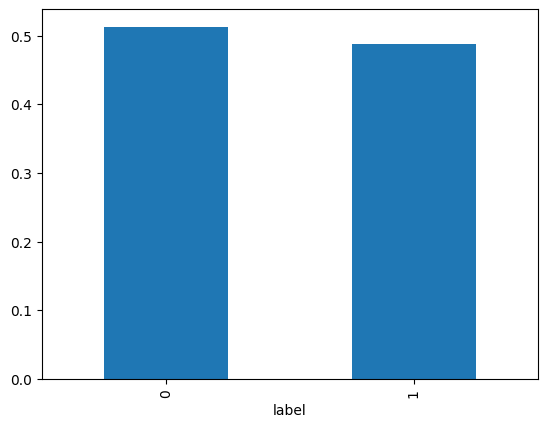

In [84]:
df.label.value_counts(normalize=True).plot(kind='bar')
#data is well balenced

### Building the preprocessing pipeline

In [85]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
", ".join (stop_words)
negative_stopwords = {
    "not", "no", "never", "isn't", "aren't", "wasn't", "weren't", "can't", 
    "couldn't", "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", 
    "shouldn't", "mustn't", "haven't", "hasn't", "hadn't", "ain't", "mightn't", 
    "needn't", "nor", "nothing", "nowhere", "none", "neither", "without", "lack"
}
stop_words -= negative_stopwords

lemmatizer = WordNetLemmatizer()
stemmer=SnowballStemmer(language='english')
def processing(text):
    text=text.lower()
    text=emoji.demojize(text)
    text=re.sub(r"https?://\S+|www\.\S+", "", text)#for links
    text = re.sub(r"[^\w\s]", "", text)  # for punctuation
    text = re.sub(r"\d+", "", text)  # for numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    tokens = word_tokenize(text) 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # for stopwords
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)
df["cleanedtxt"]=df['text'].apply(processing)




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Splitting the data

In [86]:
from sklearn.model_selection import train_test_split
traindata,testdata=train_test_split(df,test_size=0.2,random_state=42)

In [87]:
testtt=processing("I do not  no (love)-? going to my friends ")
testtt

'not no love go friend'

In [88]:
pd.set_option("display.max_colwidth", None)
print(df.head(1))
df.to_csv("preprocessed_tweets.csv", index=False)


### Building the TF-IDF

In [89]:
vectorizer = TfidfVectorizer(max_features=4000,
                                   max_df=0.8,
                                   min_df=10,    
                                   ngram_range=(1,2), 
                                   tokenizer=word_tokenize,
                                   lowercase=False, 
                                   preprocessor=None)

In [90]:
vectorizer.fit(traindata.cleanedtxt)

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(lowercase=False, max_df=0.8, max_features=4000, min_df=10,
                ngram_range=(1, 2),
                tokenizer=<function word_tokenize at 0x00000248302E2480>)

In [91]:
len(vectorizer.vocabulary_)
vectorizer.get_feature_names_out()[: 200]

array(['abandon', 'abil', 'abl', 'aboard', 'absent', 'absolut',
       'absolut no', 'absorb', 'absurd', 'abus', 'academi',
       'academi award', 'accent', 'accept', 'access', 'accid', 'accident',
       'acclaim', 'accompani', 'accomplish', 'accord', 'account', 'accur',
       'accus', 'ace', 'achiev', 'acid', 'acknowledg', 'across', 'act',
       'act like', 'action', 'action film', 'action hero', 'action movi',
       'action scene', 'action sequenc', 'activ', 'actor', 'actor play',
       'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict',
       'addit', 'address', 'adequ', 'admir', 'admit', 'adopt', 'ador',
       'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic',
       'advis', 'advoc', 'affair', 'affect', 'affleck', 'aforement',
       'afraid', 'africa', 'african', 'afterward', 'age', 'agent', 'ago',
       'agre', 'ahead', 'aid', 'aim', 'aint', 'air', 'airplan', 'al',
       'ala', 'alan', 'albeit', 'albert', 'alcohol', 'alec', 'alex',
       'alfr', 

In [92]:
inputs=vectorizer.transform(traindata.cleanedtxt)
inputs.shape

(1323, 4000)

In [93]:
inputs.toarray()[0][:100]

array([0.        , 0.        , 0.05871816, 0.        , 0.        ,
       0.06767439, 0.09853939, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07942672,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [127]:
selector = SelectKBest(chi2, k=2000)
inputs_selected = selector.fit_transform(inputs, traindata.label)

# splitting data into train and val sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_selected, traindata.label, test_size=0.2, random_state=42
)


    Text data was vectorized using TF-IDF with n-grams (1,2) and feature selection (Chi-Square, k=2000).
     The dataset was split into training (80%) and validation (20%) sets.

In [128]:
test_inputs=vectorizer.transform(testdata.cleanedtxt)
test_inputs_selected = selector.transform(test_inputs)
test_inputs.shape


(331, 4000)

In [129]:
#train_size=1000 
#train_inputs=inputs[:train_size]
#train_targets=df.label[:train_size]
#train_inputs.shape,train_targets.shape
#df.label[:train_size]
#val_inputs=inputs[train_size:]
#val_targets=df.label[train_size:]
#val_inputs.shape,val_targets.shape

### NAIVE BAYES Traning(BASELINE MODEL)

##### Grid search been used in picking the right parameters in the following steps but been removed at the end to imporve code readability

In [130]:
NB = MultinomialNB(alpha=0.1)
#Cross Validation
CV_scores = cross_val_score(NB, inputs_selected, traindata.label, cv=10, scoring="accuracy")
print(f"Cross-Validation Mean Accuracy: {CV_scores.mean():.4f}")
print(f"Cross-Validation Standard Deviation: {CV_scores.std():.4f}")

NB.fit(train_inputs, train_targets)

Cross-Validation Mean Accuracy: 0.8700
Cross-Validation Standard Deviation: 0.0245


MultinomialNB(alpha=0.1)

In [131]:
train_preds=NB.predict(train_inputs)
train_acc=accuracy_score(train_targets,train_preds)
print(f"train Accuracy for naive bayes: {train_acc:.4f}")
val_preds=NB.predict(val_inputs)
val_acc=accuracy_score(val_targets,val_preds)
print(f"NB validation Accuracy: {val_acc:.4f}")


train Accuracy for naive bayes: 0.9310
NB validation Accuracy: 0.8906


    Training score is 0.92 while validation score is 0.77 there's huge gap thus overfitting
    After tuning alpha parameter in NB the training score became 0.95 and the validation score became 0.78 (MORE OVERFITTING)
    After decreasing max_features and max_df and ngrm_range and increasing min_df parameters training score became 0.94 and the validation score became 0.78
    USING Feature Selection (Chi-Square) training score became 0.93 and the validation score became 0.80 (GREAT RESULT)  now we can experment on test data

In [132]:
test_preds = NB.predict(test_inputs_selected)
test_acc = accuracy_score(testdata.label, test_preds)
print(f"NB Test Accuracy: {test_acc:.4f}")


NB Test Accuracy: 0.8097


### SVM Training


In [133]:
svm_model = SVC(kernel='rbf', C=0.8, gamma=0.2, random_state=42)
#Cross Validation
CV_scores_svm = cross_val_score(svm_model, inputs_selected, traindata.label, cv=10, scoring="accuracy")
print(f"SVM Cross-Validation Mean Accuracy: {CV_scores_svm.mean():.4f}")
print(f"SVM Cross-Validation Standard Deviation: {CV_scores_svm.std():.4f}")
svm_model.fit(train_inputs, train_targets)

SVM Cross-Validation Mean Accuracy: 0.8767
SVM Cross-Validation Standard Deviation: 0.0371


SVC(C=0.8, gamma=0.2, random_state=42)

In [134]:
train_preds_svm = svm_model.predict(train_inputs)
train_acc_svm = accuracy_score(train_targets, train_preds_svm)
print(f"SVM Training Accuracy: {train_acc_svm:.4f}")

val_preds_svm = svm_model.predict(val_inputs)
val_acc_svm = accuracy_score(val_targets, val_preds_svm)
print(f"SVM Validation Accuracy: {val_acc_svm:.4f}")
test_preds_svm = svm_model.predict(test_inputs_selected)
test_acc = accuracy_score(testdata.label, test_preds_svm)

print(f"SVM Test Accuracy: {test_acc:.4f}")


SVM Training Accuracy: 0.9234
SVM Validation Accuracy: 0.9057
SVM Test Accuracy: 0.8278


### Random Forests Training

In [135]:
rf_model = RandomForestClassifier(
    n_estimators=300, 
    min_samples_leaf=2,  
    min_samples_split=15,  
    max_depth=30, 
    max_features='sqrt',
    bootstrap=True,
    criterion='entropy',
    min_impurity_decrease=0.01, 
    class_weight='balanced', 
    random_state=42
)

CV_scores_rf = cross_val_score(rf_model, inputs_selected, traindata.label, cv=10, scoring="accuracy")
print(f"Random Forest Cross-Validation Mean Accuracy: {CV_scores_rf.mean():.4f}")
print(f"Random Forest Cross-Validation Standard Deviation: {CV_scores_rf.std():.4f}")

rf_model.fit(train_inputs, train_targets)

Random Forest Cross-Validation Mean Accuracy: 0.8103
Random Forest Cross-Validation Standard Deviation: 0.0257


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, min_impurity_decrease=0.01,
                       min_samples_leaf=2, min_samples_split=15,
                       n_estimators=300, random_state=42)

In [136]:
train_preds_rf = rf_model.predict(train_inputs)
train_acc_rf = accuracy_score(train_targets, train_preds_rf)
print(f"Random Forest Training Accuracy: {train_acc_rf:.4f}")

val_preds_rf = rf_model.predict(val_inputs)
val_acc_rf = accuracy_score(val_targets, val_preds_rf)
print(f"Random Forest Validation Accuracy: {val_acc_rf:.4f}")

test_preds_rf = rf_model.predict(test_inputs_selected)
test_acc = accuracy_score(testdata.label, test_preds_rf)
print(f"RF Test Accuracy: {test_acc:.4f}")


Random Forest Training Accuracy: 0.9338
Random Forest Validation Accuracy: 0.8340
RF Test Accuracy: 0.8338


In [137]:
# Naive Bayes
nb_report = classification_report(val_targets, NB.predict(val_inputs))
nb_macro_f1 = f1_score(val_targets, NB.predict(val_inputs), average='macro')

# SVM
svm_report = classification_report(val_targets, svm_model.predict(val_inputs))
svm_macro_f1 = f1_score(val_targets, svm_model.predict(val_inputs), average='macro')

# Random Forest
rf_report = classification_report(val_targets, rf_model.predict(val_inputs))
rf_macro_f1 = f1_score(val_targets, rf_model.predict(val_inputs), average='macro')

print("Naive Bayes\n", nb_report)
print("SVM\n", svm_report)
print("Random Forest\n", rf_report)

print(f"Naive Bayes Macro F1-score: {nb_macro_f1:.4f}")
print(f"SVM Macro F1-score: {svm_macro_f1:.4f}")
print(f"Random Forest Macro F1-score: {rf_macro_f1:.4f}")


Naive Bayes
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       149
           1       0.84      0.92      0.88       116

    accuracy                           0.89       265
   macro avg       0.89      0.89      0.89       265
weighted avg       0.89      0.89      0.89       265

SVM
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       149
           1       0.86      0.93      0.90       116

    accuracy                           0.91       265
   macro avg       0.90      0.91      0.90       265
weighted avg       0.91      0.91      0.91       265

Random Forest
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       149
           1       0.75      0.92      0.83       116

    accuracy                           0.83       265
   macro avg       0.84      0.84      0.83       265
weighted avg       0.85      0.83      0.

## Key Observations & Conclusions
#### 1.All models performed similarly after hyperparameter tuning, with mild overfitting observed in all of them.
#### 2.SVM showed the best results in terms of accuracy and F1-score, making it the most effective model for this task.
#### 3.Naïve Bayes and Random Forest also performed decently but showed slight overfitting, especially in their validation performance.
